In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/dblp-scholar-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar-reduced/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['idf'],
                        numeric_sim_metrics=[],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False)

Number of inputs to dense layer: 3


# Train model 

In [78]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=8192,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/1
432038/432038 [==============================] - 5s 11us/step - loss: 0.0047 - acc: 0.9991 - val_loss: 0.0050 - val_acc: 0.9990


# Learning curves

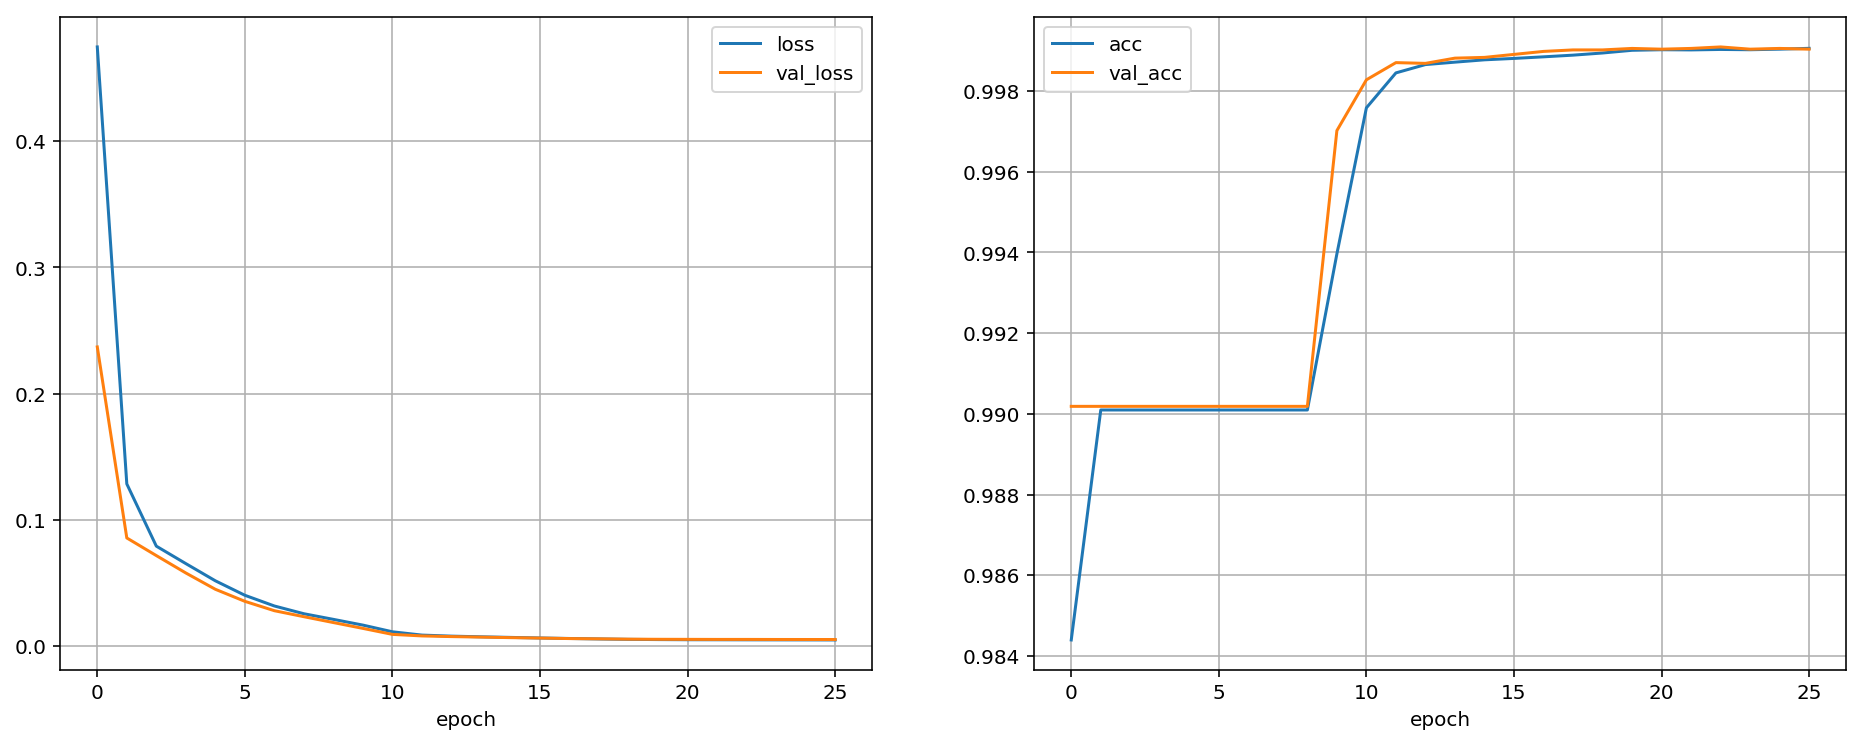

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [80]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53474
          1       0.98      0.92      0.95       530

avg / total       1.00      1.00      1.00     54004

[[53463    11]
 [   41   489]]


In [64]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,title,authors,venue,year,id2,title,authors,venue,year
49469,conf/vldb/VassalosP97,describing and using query capabilities of heterogeneous sources,vassalos papakonstantinou,vldb,1997,_Va8sQkrP2kJ,describing andusingquerycapabilities ofheterogeneous sources,vassalosandy,proceedings of international conference on very large,0.0
23432,conf/sigmod/OlstonJW03,adaptive filters for continuous queries over distributed data streams,olston jiang widom,sigmod conference,2003,fW0CpIqoV7QJ,widomj 2003 adaptivefiltersforcontinuous queries over distributed data streams,jj olstonc,proceedings of acm sigmod,0.0
43035,conf/vldb/Amer-YahiaCD98,techniques for object databases and an application to relational data,cluet delobel,vldb,1998,uA2hKrKiu6cJ,bulk loading techniques for object databases and an application to relational data,bp inria,nan,0.0
10237,conf/vldb/ChaudhuriS94,including in query optimization,chaudhuri shim,vldb,1994,FNqBp7hox0kJ,ans shim including in query optimization,chaudhuri,proceedings of the 2th vldb conference,0.0
3788,conf/sigmod/RoussopoulosKV95,nearest neighbor queries,roussopoulos kelley vincent,sigmod conference,1995,y8Sm4Sh4hokJ,vincent nearest neighbor,rossopoulos kelly,of pages,0.0


# Save model and histories 

In [65]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-base-idf.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-idf')

# Test model 

In [4]:
model.load_weights('../data/models/dblp-scholar-base-idf')
y_test_pred = model.predict(X_test, batch_size=8192)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99929   0.99983   0.99956     53467
          1    0.98232   0.92937   0.95511       538

avg / total    0.99912   0.99913   0.99912     54005

[[53458     9]
 [   38   500]]
